This is the second iteration of my Titanic project. In this iteration, I'll attempt to train alternate types of classification models in an attempt to increase predictive performance of the initial Logit model. The goal of this iteration will again focus on improving F1-score with the same dataset. An F1-score greater than 0.78 will be considered a success.

In [82]:
# Imports
# Basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mping
import seaborn as sns
import warnings

# Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier

# Model functions
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve, \
precision_score, recall_score, f1_score, auc
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, StratifiedKFold, \
RandomizedSearchCV

In [83]:
# Load in train dataset
train_preprocessed = pd.read_csv('train_preprocessed.csv')
print(train_preprocessed.head())

     Pclass       Sex       Age     SibSp     Parch      Fare  Survived
0  0.825209 -0.735342 -0.185193  0.431350 -0.474326 -0.908614         0
1 -1.572211  1.359911  0.591144  0.431350 -0.474326  1.374828         1
2  0.825209  1.359911  0.052098 -0.475199 -0.474326 -0.819680         1
3 -1.572211  1.359911  0.474329  0.431350 -0.474326  1.080629         1
4  0.825209 -0.735342  0.474329 -0.475199 -0.474326 -0.804045         0


In [84]:
# Split the data
label = train_preprocessed['Survived']
features = train_preprocessed.drop('Survived', axis=1)
X_train, X_test, y_train, y_test = train_test_split(features, label,
                                                    stratify=label,
                                                    random_state=206)

To help determine whether a weighted k-nearest neighbors model would be beneficial to employ, I'll visualize feature outliers with a boxplot.

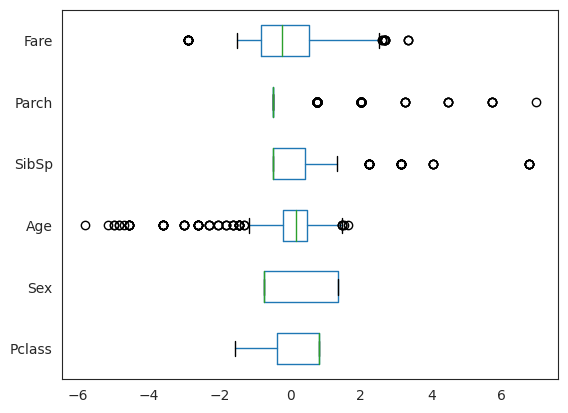

<Figure size 640x480 with 0 Axes>

In [85]:
# Plot features
features.boxplot(vert=False)
plt.grid(False)
plt.show()
plt.clf()

It appears there are many outliers in the features, therefore I'll train two k-NN models; one weighted, one not. I'll evaluate both models throughout the tuning process.

In [86]:
# Instantiate k-NN models
knn = KNeighborsClassifier()
knn_weighted = KNeighborsClassifier(weights='distance')

# Run base predictions
knn.fit(X_train, y_train)
knn_weighted.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
knn_weighted_pred = knn_weighted.predict(X_test)

# Define model metrics
def model_metrics(y_test, y_pred):
  """Prints precision, recall, F1-score and confusion matrix."""
  print(f'Precision: {precision_score(y_test, y_pred):.2f}')
  print(f'Recall: {recall_score(y_test, y_pred):.2f}')
  print(f'F1 Score: {f1_score(y_test, y_pred):.2f}')
  print('Confusion Matrix:')
  print(confusion_matrix(y_test, y_pred))

# Print model metrics
print('--Base k-NN Model--')
model_metrics(y_test, knn_pred)
print('\n--Weighted k-NN Model--')
model_metrics(y_test, knn_weighted_pred)

--Base k-NN Model--
Precision: 0.68
Recall: 0.74
F1 Score: 0.71
Confusion Matrix:
[[109  29]
 [ 22  63]]

--Weighted k-NN Model--
Precision: 0.67
Recall: 0.73
F1 Score: 0.70
Confusion Matrix:
[[107  31]
 [ 23  62]]


The standard model slightly outperforms the weighted model despite the nature of the data. I'll begin with hyperparameter tuning next.

In [111]:
# Create a parameter grid for unweighted model
params = {
    'n_neighbors': range(1, 36),
    'p': [1, 2]
}

# Reinstantiate models
knn = KNeighborsClassifier(algorithm='brute', n_jobs=-1)
knn_weighted = KNeighborsClassifier(weights='distance', algorithm='brute',
                                    n_jobs=-1)

# Create KFold object
skf = StratifiedKFold(shuffle=True, random_state=206)

# Run cross-validation
knn_cv = GridSearchCV(knn, params, scoring='f1', cv=skf, n_jobs=-1)
knn_weighted_cv = GridSearchCV(knn_weighted, params, scoring='f1', cv=skf,
                               n_jobs=-1)
warnings.filterwarnings('ignore', category=RuntimeWarning)  # warning checked
knn_cv.fit(X_train, y_train)
knn_weighted_cv.fit(X_train, y_train)

# Print best parameters
print('Unweighted k-NN: ', knn_cv.best_params_)
print('Weighted k-NN: ', knn_weighted_cv.best_params_)

Unweighted k-NN:  {'n_neighbors': 11, 'p': 1}
Weighted k-NN:  {'n_neighbors': 19, 'p': 2}


Now I'll run predictions again and evaluate the tuned models.

In [116]:
# Instantiate tuned models
knn_tuned = KNeighborsClassifier(n_neighbors=11, algorithm='brute', p=1,
                                 n_jobs=-1)
knn_weighted_tuned = KNeighborsClassifier(n_neighbors=19, weights='distance',
                                          algorithm='brute', n_jobs=-1)

# Prediction probabilities
knn_tuned.fit(X_train, y_train)
knn_weighted_tuned.fit(X_train, y_train)
knn_tuned_pred_proba = knn_tuned.predict_proba(X_test)
knn_weighted_tuned_pred_proba = knn_weighted_tuned.predict_proba(X_test)

# Calculate PR curve variables
knn_tuned_precision, knn_tuned_recall, knn_tuned_thresholds = \
precision_recall_curve(y_test, knn_tuned_pred_proba[:, 1])
knn_weighted_tuned_precision, knn_weighted_tuned_recall, \
knn_weighted_tuned_thresholds = precision_recall_curve(
    y_test, knn_weighted_tuned_pred_proba[:, 1]
)

# Define remove_zeros
def remove_zeros(precision, recall):
  """Removes zero values from precision and recall arrays."""
  precision = precision[precision != 0][:-1]
  recall = recall[recall != 0]
  return precision, recall

# Remove zeroes
knn_tuned_precision, knn_tuned_recall = remove_zeros(knn_tuned_precision,
                                                      knn_tuned_recall)
knn_weighted_tuned_precision, knn_weighted_tuned_recall = \
remove_zeros(knn_weighted_tuned_precision, knn_weighted_tuned_recall)

# Define optimal_threshold
def optimal_threshold(precision, recall, thresholds):
  """Returns optimal threshold and F1-score, as well as the index location of
  the calculated array of F1-scores from the precision_recall_curve()
  output."""

  # Calculate F1-scores
  f1_scores = 2 * ((precision * recall) / (precision + recall))

  # Isolate index of highest score
  optimal_idx = np.argmax(f1_scores)

  # Isolate threshold of highest score
  optimal_th = thresholds[optimal_idx]

  # Isolate highest score
  optimal_f1 = f1_scores[optimal_idx]

  # Return isolated values
  return optimal_idx, optimal_th, optimal_f1

# Isolate optimal thresholds, F1-scores
knn_tuned_idx, knn_tuned_th, knn_tuned_f1 = optimal_threshold(
    knn_tuned_precision, knn_tuned_recall, knn_tuned_thresholds
)
knn_weighted_tuned_idx, knn_weighted_tuned_th, knn_weighted_tuned_f1 = \
optimal_threshold(knn_weighted_tuned_precision, knn_weighted_tuned_recall,
                  knn_weighted_tuned_thresholds)

# Print optimal thresholds
print(f'Standard k-NN Optimal Threshold: {knn_tuned_th:.2f}')
print(f'Weighted k-NN Optimal Threshold: {knn_weighted_tuned_th:.2f}')

Standard k-NN Optimal Threshold: 0.36
Weighted k-NN Optimal Threshold: 0.31


Standard k-NN AUC-PR: 0.55
Weighted k-NN AUC-PR: 0.49 



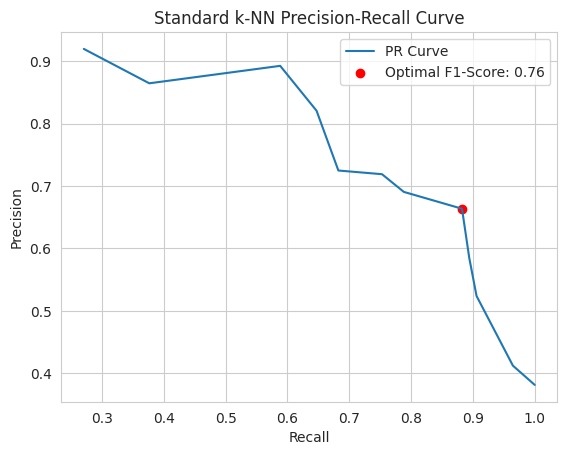

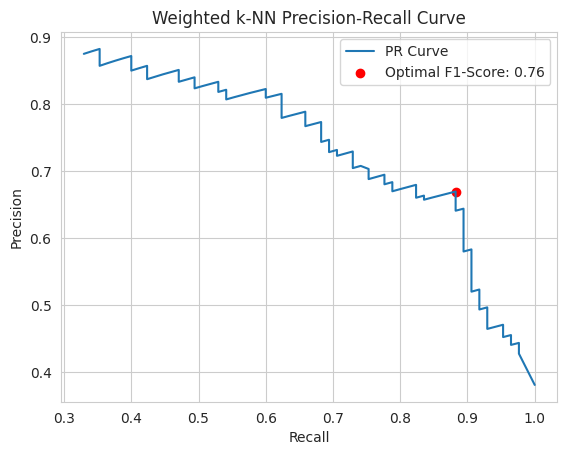

<Figure size 640x480 with 0 Axes>

In [117]:
# Calculate AUC-PRs
knn_tuned_auc = auc(knn_tuned_recall, knn_tuned_precision)
knn_weighted_tuned_auc = auc(knn_weighted_tuned_recall,
                             knn_weighted_tuned_precision)
print(f'Standard k-NN AUC-PR: {knn_tuned_auc:.2f}')
print(f'Weighted k-NN AUC-PR: {knn_weighted_tuned_auc:.2f}', '\n')

# Define plot_prc
def plot_prc(name, recall, precision, optimal_idx, optimal_f1):
  """Plots precision-recall curve."""
  plt.plot(recall, precision, label='PR Curve')
  plt.scatter(recall[optimal_idx], precision[optimal_idx], marker='o', c='r',
              label=f'Optimal F1-Score: {optimal_f1:.2f}')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title(name + ' Precision-Recall Curve')
  plt.legend()
  plt.show()

# Plot PR curves
sns.set_style('whitegrid')
plot_prc('Standard k-NN', knn_tuned_recall, knn_tuned_precision,
         knn_tuned_idx, knn_tuned_f1)
plt.clf()
plot_prc('Weighted k-NN', knn_weighted_tuned_recall,
         knn_weighted_tuned_precision, knn_weighted_tuned_idx,
         knn_weighted_tuned_f1)
plt.clf()

In [118]:
# Optimal threshold preidctions
knn_y_pred_optimal = (knn_tuned_pred_proba[:, 1] >= knn_tuned_th).astype('int')
knn_weighted_y_pred_optimal = (knn_weighted_tuned_pred_proba[:, 1] >=
                               knn_weighted_tuned_th).astype('int')

# View model metrics
print('--Standard KNN--')
model_metrics(y_test, knn_y_pred_optimal)
print('\n--Weighted KNN--')
model_metrics(y_test, knn_weighted_y_pred_optimal)

--Standard KNN--
Precision: 0.66
Recall: 0.88
F1 Score: 0.76
Confusion Matrix:
[[100  38]
 [ 10  75]]

--Weighted KNN--
Precision: 0.67
Recall: 0.88
F1 Score: 0.76
Confusion Matrix:
[[101  37]
 [ 10  75]]


Looks like the tuned models perform better! The non-weighted model saw a major gain in recall at the slight expense of precision boosting F1 by 0.05, only 0.02 behind Logit! The weighted model experienced the same boost but still slightly behind the unweighted model. I'll now visualize the F1-score by number of neighbors to compare each model.

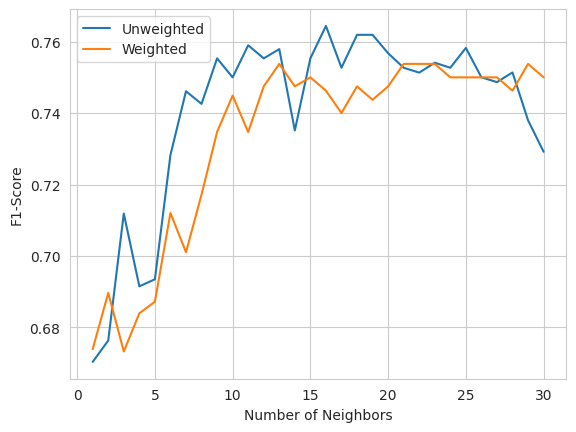

In [119]:
# Create array values to plot
uw_ks = np.arange(1, 31)
uw_f1s = np.zeros(30)
w_ks = np.arange(1, 31)
w_f1s = np.zeros(30)

# Loop through models
for neighbors in uw_ks:
  knn = KNeighborsClassifier(n_neighbors=neighbors, algorithm='brute',
                             n_jobs=-1)
  knn.fit(X_train, y_train)
  uw_pred = (knn.predict_proba(X_test)[:, 1] >= knn_tuned_th).astype('int')
  uw_f1s[neighbors - 1] = f1_score(y_test, uw_pred)

for neighbors in w_ks:
  knn = KNeighborsClassifier(n_neighbors=neighbors, weights='distance',
                             algorithm='brute', p=1, n_jobs=-1)
  knn.fit(X_train, y_train)
  w_pred = (knn.predict_proba(X_test)[:, 1] >= knn_weighted_tuned_th)\
           .astype('int')
  w_f1s[neighbors - 1] = f1_score(y_test, w_pred)

# Plot values
plt.figure()
plt.plot(uw_ks, uw_f1s, label='Unweighted')
plt.plot(w_ks, w_f1s, label='Weighted')
plt.xlabel('Number of Neighbors')
plt.ylabel('F1-Score')
plt.legend()
plt.show()
plt.close()

It's clear that the unweighted model is the better learner but the weighted model isn't far behind.

To better understand the strengths and weaknesses of k-NN predictions, I'll compare them with the output of Logit.

In [120]:
# Load Logit predictions
lgt_pred = np.loadtxt('lgt_pred').astype('int')

# Create predictions DataFrame
predictions = pd.DataFrame({
    'Logit': lgt_pred,
    'k-NN': knn_y_pred_optimal
})

print('Number of different predictions: ',
      predictions[predictions['Logit'] != predictions['k-NN']].shape[0])

Number of different predictions:  25


There is only a small number of differences in predictions. To better understand the behavior of the models, I'll plot their decision boundaries.

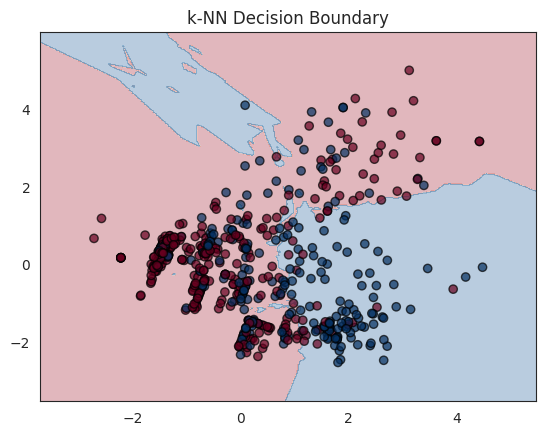

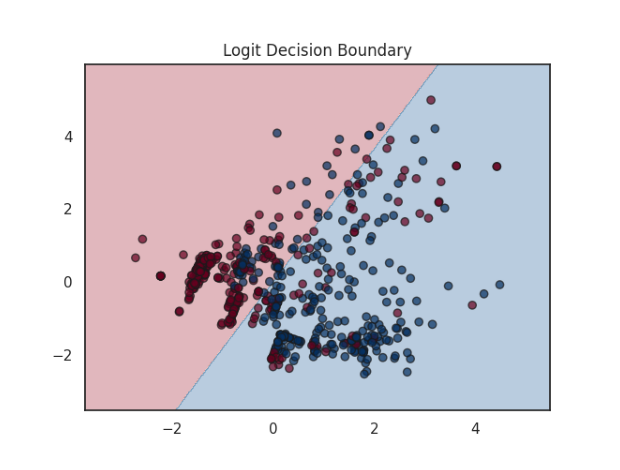

In [121]:
# Define plot_db
def plot_db(model, X, y, optimal_th, name=None):
  """Plots decision boundary of model."""
  x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                       np.arange(y_min, y_max, 0.02))
  Z_prob = model.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
  Z = (Z_prob >= optimal_th).astype('int')
  Z = Z.reshape(xx.shape)
  plt.contourf(xx, yy, Z, alpha=0.3, cmap='RdBu')
  plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.7, edgecolor='k', cmap='RdBu')
  plt.title(name + ' Decision Boundary')
  plt.show()

# Reduce model dimensionality
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)

# Plot KNN decision boundary
warnings.filterwarnings('ignore', category=UserWarning)  # warning checked
sns.set_style('white')
plot_db(knn_tuned, X_train_pca, y_train, knn_tuned_th, 'k-NN')
plt.clf()

# Import Logit decision boundary plot
lgt_db = mping.imread('lgt_db.png')
plt.axis('off')
plt.tight_layout()
plt.imshow(lgt_db)

Pretty interesting seeing the different way in which k-NN paints its decisions. The non-linear relationships in the data are clear to see. Moving forward, I'll instantiate a decision tree model and evaluate its performance.

In [122]:
# Set class weights variable
weights = {0: 0.618, 1: 0.382}

# Instantiate base decision tree
dt = DecisionTreeClassifier(random_state=206, class_weight=weights)

# Run base predictions
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)

# Print model metrics
print('--Base Decision Tree--')
model_metrics(y_test, dt_pred)

--Base Decision Tree--
Precision: 0.68
Recall: 0.69
F1 Score: 0.69
Confusion Matrix:
[[110  28]
 [ 26  59]]


The base model performance underperforms both Logit and k-NN, but let's see if cross-validation can't improve the scores. Since I'll be testing a large parameter set, I'll begin with randomized search and end with a comprehensive grid search using the results.

In [123]:
# Create a parameter grid
params = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
    'min_samples_split': np.arange(2, 22, 2),
    'min_samples_leaf': np.arange(1, 11),
    'max_leaf_nodes': [None, 10, 20, 30, 40, 50, 60, 70, 80]
}

# Create kfold object
skf = StratifiedKFold(shuffle=True, random_state=206)

# Run cross-validation
dt_cv = RandomizedSearchCV(
    DecisionTreeClassifier(random_state=206, class_weight=weights),
    params, n_iter=400, scoring='f1', cv=skf, n_jobs=-1, random_state=206,
    verbose=1)
dt_cv.fit(X_train, y_train)
print(dt_cv.best_params_)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits
{'splitter': 'best', 'min_samples_split': 12, 'min_samples_leaf': 8, 'max_leaf_nodes': 50, 'max_depth': 6, 'criterion': 'log_loss'}


In [141]:
# Refine parameter grid
params = {
    'max_depth': np.arange(4, 14),
    'min_samples_split': np.arange(10, 20),
    'min_samples_leaf': np.arange(6, 11),
    'max_leaf_nodes': np.arange(45, 56)
}

# Run grid search
dt_cv = RandomizedSearchCV(
    DecisionTreeClassifier(criterion='log_loss', splitter='best',
                           random_state=206, class_weight=weights),
    params, n_iter=400, scoring='f1', cv=skf, n_jobs=-1, random_state=206,
    verbose=1)
dt_cv.fit(X_train, y_train)
print(dt_cv.best_params_)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits
{'min_samples_split': 17, 'min_samples_leaf': 7, 'max_leaf_nodes': 49, 'max_depth': 8}


In [156]:
# Refine parameter grid
params = {
    'max_depth': np.arange(8, 11),
    'min_samples_split': np.arange(1, 4),  # sharp decrease observed
    'min_samples_leaf': np.arange(5, 8),
    'max_leaf_nodes': np.arange(15, 20)  # sharp decrease observed
}

# Run grid search
dt_cv = GridSearchCV(
    DecisionTreeClassifier(criterion='log_loss', splitter='best',
                           random_state=206, class_weight=weights),
    params, scoring='f1', cv=skf, n_jobs=-1, verbose=1)
dt_cv.fit(X_train, y_train)
print(dt_cv.best_params_)

Fitting 5 folds for each of 135 candidates, totalling 675 fits
{'max_depth': 9, 'max_leaf_nodes': 18, 'min_samples_leaf': 6, 'min_samples_split': 2}


In [157]:
# Test new hyperparameters
params = {
    'min_weight_fraction_leaf': np.arange(0.0, 0.5, 0.05),
    'ccp_alpha': np.arange(0.0, 0.5, 0.05)
}

# Re-run grid search
dt_cv = GridSearchCV(
    DecisionTreeClassifier(criterion='log_loss', splitter='best', max_depth=9,
                           min_samples_leaf=6, max_leaf_nodes=18,
                           random_state=206, class_weight=weights),
    params, scoring='f1', cv=skf, n_jobs=-1, verbose=1)
dt_cv.fit(X_train, y_train)
print(dt_cv.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'ccp_alpha': 0.0, 'min_weight_fraction_leaf': 0.0}


Now to instantiate a tuned decision tree and isolate the best threshold.

In [158]:
# Instantiate tuned model
dt_tuned = DecisionTreeClassifier(criterion='gini', splitter='best',
                                  max_depth=13, min_samples_leaf=9,
                                  max_leaf_nodes=9, random_state=206,
                                  class_weight=weights)

# Prediction probabilities
dt_tuned.fit(X_train, y_train)
dt_tuned_pred_proba = dt_tuned.predict_proba(X_test)

# Calculate PR curve variables
dt_tuned_precision, dt_tuned_recall, dt_tuned_thresholds = \
precision_recall_curve(y_test, dt_tuned_pred_proba[:, 1])

# Isolate optimal thresholds, F1-scores
dt_tuned_precision, dt_tuned_recall = remove_zeros(dt_tuned_precision,
                                                   dt_tuned_recall)
dt_tuned_idx, dt_tuned_th, dt_tuned_f1 = optimal_threshold(
    dt_tuned_precision, dt_tuned_recall, dt_tuned_thresholds
)
print(f'Optimal Threshold: {dt_tuned_th:.2f}')

Optimal Threshold: 0.47


AUC-PR: 0.81


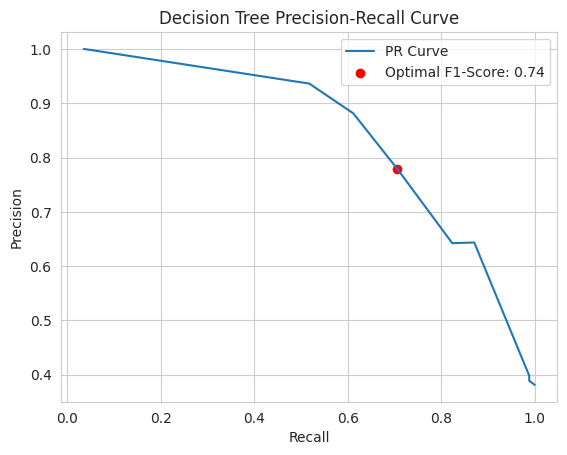

In [166]:
# Calculate AUC-PR
print(f'AUC-PR: {auc(dt_tuned_recall, dt_tuned_precision):.2f}')

# Plot PR curve
sns.set_style('whitegrid')
plot_prc('Decision Tree', dt_tuned_recall, dt_tuned_precision,
         dt_tuned_idx, dt_tuned_f1)

In [160]:
# Optimal threshold predictions
dt_y_pred_optimal = (dt_tuned_pred_proba[:, 1] >= dt_tuned_th).astype('int')

# View model metrics
print('--Base Decision Tree--')
model_metrics(y_test, dt_pred)
print('\n--Tuned Decision Tree--')
model_metrics(y_test, dt_y_pred_optimal)

--Base Decision Tree--
Precision: 0.68
Recall: 0.69
F1 Score: 0.69
Confusion Matrix:
[[110  28]
 [ 26  59]]

--Tuned Decision Tree--
Precision: 0.78
Recall: 0.71
F1 Score: 0.74
Confusion Matrix:
[[121  17]
 [ 25  60]]


Looks like the precision and overall F1-score was boosted a good bit. I'm curious now how many predictions differ between all the models.

In [163]:
# Add the decision tree's predictions to the predictions DataFrame
predictions['Decision Tree'] = dt_y_pred_optimal

# Evaluate number of difference predictions between models
print('--Number of Different Predictions--',
      '\nLogit / k-Nearest Neighbors: ',
      predictions[predictions['Logit'] != predictions['k-NN']].shape[0],
      '\nLogit / Decision Tree: ',
      predictions[predictions['Logit'] != predictions['Decision Tree']].shape[0],
      '\nK-Nearest Neighbors / Decision Tree: ',
      predictions[predictions['k-NN'] != predictions['Decision Tree']].shape[0])

--Number of Different Predictions-- 
Logit / k-Nearest Neighbors:  25 
Logit / Decision Tree:  25 
K-Nearest Neighbors / Decision Tree:  36


It would seem that the models disagree but not on much. The k-NN and decision tree disagree on more, interestingly.

Since the scikit-learn LogisticRegression model I trained before performed nearly identically to the statsmodels Logit model that I used for final predictions, I'll use it for the ensemble instead for the sake of cohesion.

In [164]:
# Instantiate LogisticRegression
lr = LogisticRegression(
    penalty='l2',
    tol=0.01,
    intercept_scaling=0.1,
    max_iter=50,
    class_weight=weights,
    random_state=206,
    solver='liblinear'
)
lr.fit(X_train, y_train)

# Create first ensemble
vclf_lkd = VotingClassifier(
    estimators=[
        ('LogisticRegression', lr),
        ('k-Nearest Neighbors', knn_tuned),
        ('Decision Tree', dt_tuned)
    ],
    voting='soft',
    n_jobs=-1
)
vclf_lkd.fit(X_train, y_train)

# Create second ensemble
vclf_lk = VotingClassifier(
    estimators=[
        ('LogisticRegression', lr),
        ('k-Nearest Neighbors', knn_tuned)
    ],
    voting='soft',
    n_jobs=-1
)
vclf_lk.fit(X_train, y_train)

# Run ensemble predictions
vclf_lkd_pred = vclf_lkd.predict(X_test)
vclf_lk_pred = vclf_lk.predict(X_test)

# Print metrics
print('--Three-Model Ensemble--')
model_metrics(y_test, vclf_lkd_pred)
print('\n--Two-Model Ensemble--')
model_metrics(y_test, vclf_lk_pred)

--Three-Model Ensemble--
Precision: 0.77
Recall: 0.69
F1 Score: 0.73
Confusion Matrix:
[[120  18]
 [ 26  59]]

--Two-Model Ensemble--
Precision: 0.73
Recall: 0.76
F1 Score: 0.75
Confusion Matrix:
[[114  24]
 [ 20  65]]


It looks like the ensemble did not improve the overall performance of the individual models. To be sure, I will isolate the best thresholds for a final round of predictions.

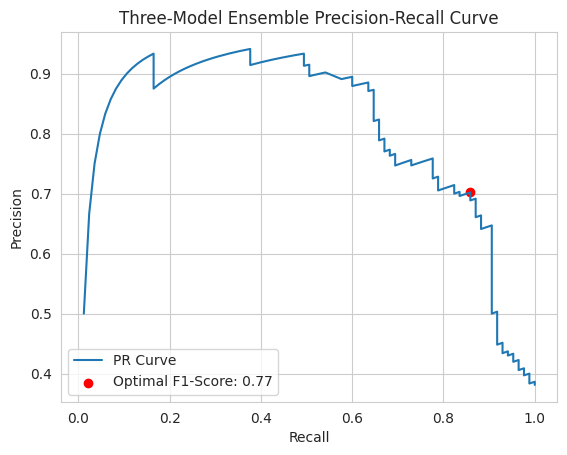

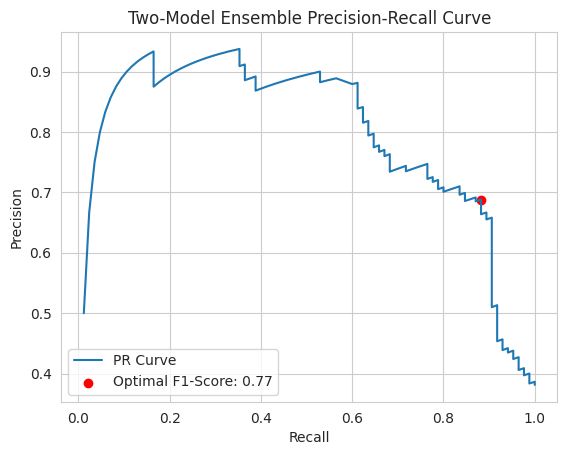

<Figure size 640x480 with 0 Axes>

In [167]:
# Isolate best thresholds
vclf_lkd_pred_proba = vclf_lkd.predict_proba(X_test)
vclf_lk_pred_proba = vclf_lk.predict_proba(X_test)

# Calculate PR curves
vclf_lkd_precision, vclf_lkd_recall, vclf_lkd_thresholds = \
precision_recall_curve(y_test, vclf_lkd_pred_proba[:, 1])
vclf_lk_precision, vclf_lk_recall, vclf_lk_thresholds = \
precision_recall_curve(y_test, vclf_lk_pred_proba[:, 1])

# Isolate thresholds, F1-scores
vclf_lkd_precision, vclf_lkd_recall = remove_zeros(vclf_lkd_precision,
                                                     vclf_lkd_recall)
vclf_lk_precision, vclf_lk_recall = remove_zeros(vclf_lk_precision,
                                                   vclf_lk_recall)
vclf_lkd_idx, vclf_lkd_th, vclf_lkd_f1 = optimal_threshold(
    vclf_lkd_precision, vclf_lkd_recall, vclf_lkd_thresholds
)
vclf_lk_idx, vclf_lk_th, vclf_lk_f1 = optimal_threshold(
    vclf_lk_precision, vclf_lk_recall, vclf_lk_thresholds
)

# Plot PR curves
plot_prc('Three-Model Ensemble', vclf_lkd_recall, vclf_lkd_precision,
         vclf_lkd_idx, vclf_lkd_f1)
plt.clf()
plot_prc('Two-Model Ensemble', vclf_lk_recall, vclf_lk_precision,
         vclf_lk_idx, vclf_lk_f1)
plt.clf()

In [168]:
# Predict with best thresholds
vclf_lkd_y_pred_optimal = (vclf_lkd_pred_proba[:, 1] >= vclf_lkd_th)\
                          .astype('int')
vclf_lk_y_pred_optimal = (vclf_lk_pred_proba[:, 1] >= vclf_lk_th)\
                         .astype('int')
lr_y_pred_optimal = (lr.predict_proba(X_test)[:, 1 ] >= 0.41).astype('int')

# View model metrics
print('--LogisticRegression--')
model_metrics(y_test, lr_y_pred_optimal)
print('\n--Three-Model Ensemble--')
model_metrics(y_test, vclf_lkd_y_pred_optimal)
print('\n--Two-Model Ensemble--')
model_metrics(y_test, vclf_lk_y_pred_optimal)

--LogisticRegression--
Precision: 0.71
Recall: 0.86
F1 Score: 0.78
Confusion Matrix:
[[108  30]
 [ 12  73]]

--Three-Model Ensemble--
Precision: 0.70
Recall: 0.86
F1 Score: 0.77
Confusion Matrix:
[[107  31]
 [ 12  73]]

--Two-Model Ensemble--
Precision: 0.69
Recall: 0.88
F1 Score: 0.77
Confusion Matrix:
[[104  34]
 [ 10  75]]


This ensemble did not perform any better than the solo LogisticRegression model. In light of this, I won't proceed with new predictions of the test.csv set using VotingClassifier. Perhaps in another iteration I'll explore a bagging classifier using LogisticRegression but, for now, this concludes the second iteration of my Titanic project.